In [97]:
# Imports
import numpy as np
import pandas as pd
from pathlib import Path
from functools import reduce
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
import arch 
from arch import arch_model
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data

In [4]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(Path("/Users/erahm/Downloads/yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [5]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

<AxesSubplot:xlabel='Date'>

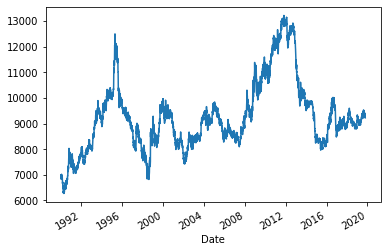

In [9]:
# Plot just the "Settle" column from the dataframe:
yen_futures['Settle'].plot()

# By plotting the "Settle" price column, we see that there is a mild long-term upward trend in the Japenese yen daily settle price.

---

# Decomposition Using a Hodrick-Prescott Filter

In [11]:
# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

<AxesSubplot:xlabel='Date'>

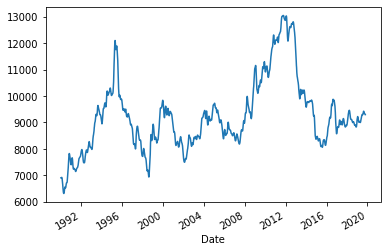

In [12]:
# Plot the trend data of the 'Settle' price
ts_trend.plot()

<AxesSubplot:xlabel='Date'>

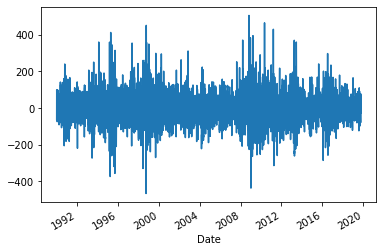

In [13]:
# Plot the noise data of the 'Settle' price
ts_noise.plot()

In [19]:
# Create a dataframe of just the Settle price column
settle_price_df = pd.DataFrame(yen_futures).drop(columns=['Open', 'High', 'Low', 'Last', 'Change', 'Volume', 'Previous Day Open Interest'])
settle_price_df

,Settle
Date,
1990-01-02,6847.0
1990-01-03,6887.0
1990-01-04,7008.0
1990-01-05,6950.0
1990-01-08,6959.0
...,...
2019-10-09,9338.0
2019-10-10,9303.5
2019-10-11,9251.0


In [34]:
# Merge the settle price, noise and trend dataframes into a single dataframe
dfs = [settle_price_df, ts_noise, ts_trend]
merged_df_final = reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs)
merged_df_final

,Settle,Settle_cycle,Settle_trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062
...,...,...,...
2019-10-09,9338.0,24.939247,9313.060753
2019-10-10,9303.5,-5.868559,9309.368559
2019-10-11,9251.0,-54.454594,9305.454594


In [46]:
# Select all rows from 2015-2022 to plot the Settle Price vs. the Trend for 2015 to the present
merged_df_final.loc['2015-01':'2022-03'].head()

,Settle,Settle_cycle,Settle_trend
Date,,,
2015-01-02,8315.0,-79.686404,8394.686404
2015-01-05,8371.0,-30.395762,8401.395762
2015-01-06,8435.0,26.414403,8408.585597
2015-01-07,8412.0,-4.089059,8416.089059
2015-01-08,8360.0,-63.755805,8423.755805


<AxesSubplot:xlabel='Date'>

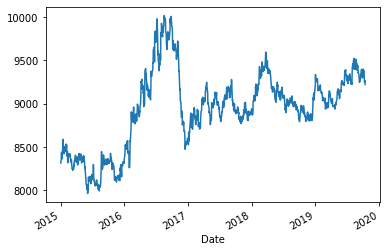

In [55]:
# Plot the Settle column from 2015 onwards
merged_df_final.Settle.loc['2015-01':'2022-03'].plot()

<AxesSubplot:xlabel='Date'>

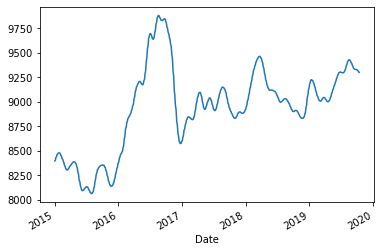

In [57]:
# Plot the Settle Trend column from 2015 onwards
merged_df_final.Settle_trend.loc['2015-01':'2022-03'].plot()

<AxesSubplot:xlabel='Date'>

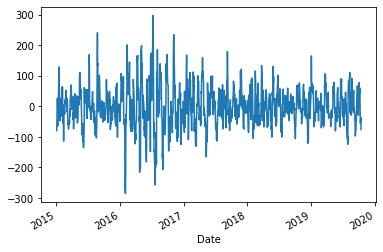

In [56]:
# Plot the Settle Noise column from 2015 onwards
merged_df_final.Settle_cycle.loc['2015-01':'2022-03'].plot()

---

# Forecasting Returns using an ARMA Model

In [58]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


<AxesSubplot:xlabel='Date'>

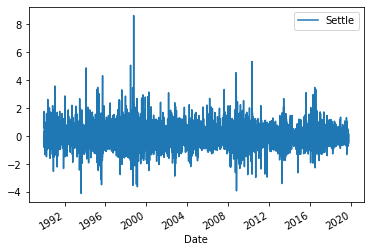

In [61]:
# View the stationarity
returns.plot()

In [73]:
# Create the ARMA model using the return values and the order
# For the order parameter, the first 2 indicates the number of AR lags
# For the order parameter, the second 1 indicates the number of MA lags
model = ARMA(returns.values, order=(2,1))

C:\Users\erahm\folder\envs\freshalpaca\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [74]:
# Fit the model to the data
results = model.fit()

In [76]:
# Summarize the model
results.summary()

# The ARMA Model shows p-values (in the the P>|z| column) are all higher than 0.05, which may mean our coefficient is unreliable and resulting in misleading results; this model does not appear to be a good fit.

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Sat, 05 Mar 2022   AIC                          15798.142
Time:                        16:20:30   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.421      -0.009       0.022
ar.L1.y       -0.3062      1.277     -0.240      0.811      -2.810       2.197
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2947      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3346           +0.0000j            3.3346            0.5000
AR.2         -157.1867           +0.0000j          157.1867            0.5000
MA.1           -3.3935           +0.0000j            3.3935            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

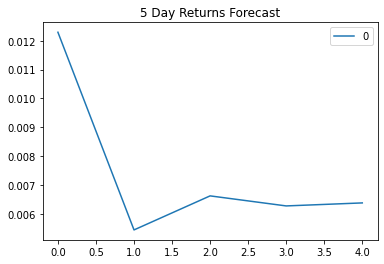

In [84]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

---

# Forecasting the Settle Price using an ARIMA Model

In [82]:
# Estimate and ARIMA Model:
model_1 = ARIMA(yen_futures['Settle'], order=(5, 1, 1))

# Fit the model
ARIMA_results = model_1.fit()

C:\Users\erahm\folder\envs\freshalpaca\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\erahm\folder\envs\freshalpaca\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [83]:
# Output model summary results:
ARIMA_results.summary()

# The ARIMA Model shows p-values (in the the P>|z| column) are all higher than 0.05, which may mean our coefficient is unreliable and resulting in misleading results; this model does not appear to be a good fit.

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Sat, 05 Mar 2022   AIC                          83905.238
Time:                        16:31:24   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3162      0.700      0.452      0.651      -1.056       1.688
ar.L1.D.Settle     0.2821      0.699      0.403      0.687      -1.088       1.652
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.065      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2971      0.699     -0.425      0.671      -1.667       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8916           -1.3786j            2.3406           -0.1002
AR.2            1.8916           +1.3786j            2.3406            0.1002
AR.3           -2.2688           -3.0220j            3.7789           -0.3525
AR.4           -2.2688           +3.0220j            3.7789            0.3525
AR.5          -11.0241           -0.0000j           11.0241           -0.5000
MA.1            3.3658           +0.0000j            3.3658            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Price Forecast'}>

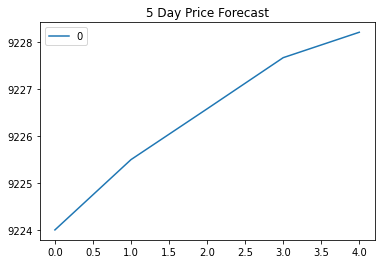

In [85]:
# Plot the 5 Day Price Forecast
pd.DataFrame(ARIMA_results.forecast(steps=5)[0]).plot(title="5 Day Price Forecast")

# In the near-term, the ARIMA model forecasts that the 5 day price will increase by 4 Japenese Jen, from 9224 to 9228.

---

# Volatility Forecasting with GARCH

In [90]:
# Estimate a GARCH model:
# 'p' and 'q' utilize the 'p' and 'q' of an ARMA model.
# 'vol="GARCH"' indiciates that this is a GARCH model.
# The 'mean="Zero"' implies that we're estimating a GARCH.
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the GARCH Model
res = model.fit(disp="off")

In [91]:
# Summarize the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Sat, Mar 05 2022   Df Residuals:                     7514
Time:                        16:53:37   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.707e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [92]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [93]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = res.forecast(start='2019-10-15', horizon=forecast_horizon, reindex=True)
forecasts

In [94]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434032,7.475729,7.516851,7.55741,7.597418


In [95]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434032
h.2,7.475729
h.3,7.516851
h.4,7.557410
h.5,7.597418


<AxesSubplot:>

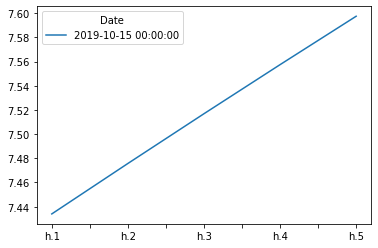

In [96]:
# Plot the final forecast
final.plot()

---

# Conclusions

Based on the model evaulation, we can see that:

1) Volatility for the Japenese Jen is expected to rise based on a very small dataset of 5 days using the GARCH model above.

2) There is a mild long-term upward trend in the Japenese Yen daily settle price based on annual settle price data from 1992-2020.

3) Based on the p-values in the ARMA and ARIMA models, the models do not appear to be a good fit since they are higher than 0.05, which may mean our coefficient is unreliable and resulting in misleading results.  I would not feel confident using these models as a result.

Given this information, I would hold off on buying Japense yen until price volatility was a bit more stable.  It does appear to be a good long-term investment, however.